In [1]:
%pip install yfinance

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 18.1 MB/s  0:00:00
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15703 sha256=c1720272f73f2e98115c6ce28b660f86c7e8ebf36b4151bcfa64a441267d09da
  Stored in directory: c:\users\new user660003\appdata\local\pip\cache\wheels\1e\df\0f\e2bbb22d689b30c681feb5410ab64a2523437b34c8ecfc6476
Successfully built multitasking

   ---------------------------------------- 0/5 [peewee]
   ---------------- ----------------------- 2/5 [websockets]
   ---------------- ----------------------- 2/5 [websockets]
   -----------

In [2]:
START_D = "2022-01-01"
END_D   = "2025-12-18"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

pd.set_option("display.max_columns", 120)

In [4]:
from __future__ import annotations

from pathlib import Path
import hashlib
import re
from io import StringIO

import numpy as np
import pandas as pd

#CONFIGURATION
CACHE_DIR = Path(".cache")
CACHE_DIR.mkdir(exist_ok=True)

#CACHE UTILITIES (PARQUET -> csv fallback)

def _hash_key(*parts: object) -> str:
    h = hashlib.sha256()
    for p in parts:
        h.update(str(p).encode("utf-8"))
        h.update(b"|")
    return h.hexdigest()[:24]
def _cache_paths(prefix: str, key: str) -> tuple[Path, Path]:
    p_parquet = CACHE_DIR / f"{prefix}_{key}.parquet"
    p_csv = CACHE_DIR / f"{prefix}_{key}.csv"
    return p_parquet, p_csv

def _read_cache_df(prefix: str, key: str) -> pd.DataFrame | None:
    p_parquet, p_csv = _cache_paths(prefix, key)
    if p_parquet.exists():
        try:
            return pd.read_parquet(p_parquet)
        except Exception:
            pass
    if p_csv.exists():
        try:
            return pd.read_csv(p_csv)
        except Exception:
            pass
    return None

def _write_cache_df(df: pd.DataFrame, prefix: str, key: str) -> None:
    p_parquet, p_csv = _cache_paths(prefix, key)
    try:
        df.to_parquet(p_parquet, index=False)
        return
    except Exception:
        pass
    try:
        df.to_csv(p_csv, index=False)
    except Exception:
        # If caching fails, ignore silently (no exceptions)
        return

# HTTP helpers

def http_get_text(url: str, timeout: int = 30, headers: dict | None = None) -> str:
    """
    Returns response text. Raises inside, but callers wrap in try/except (no exceptions to user).
    """
    import requests

    h = {
        "User-Agent": "Mozilla/5.0 (compatible; FinanceCourse/1.0)",
        "Accept": "*/*",
    }
    if headers:
        h.update(headers)

    r = requests.get(url, timeout=timeout, headers=h)
    r.raise_for_status()
    return r.text
# Numeric + returns helpers
def parse_number(x) -> float:
    """
    Robust number parser:
      - '3,367' -> 3.367 (comma decimal)
      - '1,234.56' -> 1234.56 (comma thousands)
    """
    if x is None:
        return np.nan
    s = str(x).strip()
    if s == "" or s.lower() in {"nan", "none"}:
        return np.nan

    if "," in s and "." in s:
        s = s.replace(",", "")
    elif "," in s and "." not in s:
        s = s.replace(",", ".")

    try:
        return float(s)
    except Exception:
        return np.nan

def pct_change(s: pd.Series) -> pd.Series:
    x = pd.to_numeric(s, errors="coerce")
    return x.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan)
# BCRP parsing

_SP2EN = {
    "Ene": "Jan", "Feb": "Feb", "Mar": "Mar", "Abr": "Apr", "May": "May", "Jun": "Jun",
    "Jul": "Jul", "Ago": "Aug", "Set": "Sep", "Sep": "Sep", "Oct": "Oct", "Nov": "Nov", "Dic": "Dec",
}

def _clean_bcrp_payload(txt: str) -> str:
    """
    BCRP sometimes returns "CSV" wrapped as HTML with <br> line breaks.
    Normalize to plain text with real newlines.
    """
    x = txt.replace("\r\n", "\n").replace("\r", "\n")
    x = x.replace("<br/>", "\n").replace("<br />", "\n").replace("<br>", "\n")
    x = re.sub(r"</?pre[^>]*>", "", x, flags=re.IGNORECASE)
    return x.strip()

def _detect_sep(header_line: str) -> str:
    return ";" if header_line.count(";") > header_line.count(",") else ","

def _parse_bcrp_date(s: pd.Series) -> pd.Series:
    """
    Parses common BCRP date formats:
      - Daily: 2022-01-03, 03Jan22, 03Ene22
      - Monthly: Jan22, Ene22, 2022-1, 2022-01
      - Yearly: 2022
    """
    x = s.astype(str).str.strip()
    x = x.str.replace(".", "", regex=False)

    y = x
    for k, v in _SP2EN.items():
        y = y.str.replace(k, v, regex=False)

    dt = pd.to_datetime(y, format="%Y-%m-%d", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%d%b%y", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%b%y", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%Y-%m", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%Y", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], errors="coerce")

    return dt


def bcrp_series_csv(
    series_codes: list[str],
    start: str,
    end: str,
    lang: str = "ing",
) -> pd.DataFrame:
    """
    BCRPData API (CSV):
      https://estadisticas.bcrp.gob.pe/estadisticas/series/api/[codes]/csv/[start]/[end]/[lang]

    Returns LONG DataFrame:
      date, series_name, value

    If the endpoint fails, prints a short message and returns an empty DataFrame (no exceptions).
    """
    codes = "-".join(series_codes)
    url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{codes}/csv/{start}/{end}/{lang}"

    key = _hash_key("bcrp", url)
    cached = _read_cache_df("bcrp", key)
    if cached is not None and cached.shape[0] > 0:
        cached["date"] = pd.to_datetime(cached["date"], errors="coerce")
        return cached

    try:
        txt = http_get_text(url, timeout=30)
        txt = _clean_bcrp_payload(txt)

        lines = [ln for ln in txt.split("\n") if ln.strip() != ""]
        if len(lines) < 2:
            print("[BCRP] Endpoint returned no usable rows. Continuing...")
            return pd.DataFrame(columns=["date", "series_name", "value"])

        sep = _detect_sep(lines[0])
        df = pd.read_csv(StringIO("\n".join(lines)), sep=sep)

        if df.shape[0] == 0 or df.shape[1] < 2:
            print("[BCRP] Returned an empty table. Continuing...")
            return pd.DataFrame(columns=["date", "series_name", "value"])

        date_col = df.columns[0]
        value_cols = list(df.columns[1:])

        out = df.melt(
            id_vars=[date_col],
            value_vars=value_cols,
            var_name="series_name",
            value_name="value_raw",
        ).rename(columns={date_col: "date"})

        out["date"] = _parse_bcrp_date(out["date"])
        out["value"] = out["value_raw"].map(parse_number)

        out = out.drop(columns=["value_raw"])
        out = out.dropna(subset=["date"]).sort_values(["series_name", "date"]).reset_index(drop=True)

        _write_cache_df(out, "bcrp", key)
        return out

    except Exception as e:
        print(f"[BCRP] Endpoint unavailable ({type(e).__name__}). Continuing...")
        return pd.DataFrame(columns=["date", "series_name", "value"])
# Yahoo Finance (yfinance)

def yfinance_download(tickers: list[str], start: str, end: str) -> pd.DataFrame:
    """
    Yahoo Finance via yfinance.
    Returns LONG DataFrame:
      date, ticker, close, volume, ret

    If the endpoint fails, prints a short message and returns an empty DataFrame (no exceptions).
    """
    try:
        import yfinance as yf
    except Exception:
        print("[yfinance] yfinance not installed/importable. Continuing...")
        return pd.DataFrame(columns=["date", "ticker", "close", "volume", "ret"])

    key = _hash_key("yfinance", " ".join(tickers), start, end)
    cached = _read_cache_df("yf", key)
    if cached is not None and cached.shape[0] > 0:
        cached["date"] = pd.to_datetime(cached["date"], errors="coerce")
        return cached

    try:
        data = yf.download(tickers=tickers, start=start, end=end, auto_adjust=False, progress=False)
        if data is None or data.shape[0] == 0:
            print("[yfinance] Returned no rows. Continuing...")
            return pd.DataFrame(columns=["date", "ticker", "close", "volume", "ret"])

        frames = []
        if isinstance(data.columns, pd.MultiIndex):
            for t in tickers:
                if t not in data.columns.get_level_values(1):
                    continue
                sub = data.xs(t, axis=1, level=1).copy()
                sub = sub.reset_index().rename(columns={"Date": "date", "Datetime": "date"})
                sub["ticker"] = t
                sub = sub.rename(columns={"Close": "close", "Volume": "volume"})
                frames.append(sub[["date", "ticker", "close", "volume"]])
            out = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
        else:
            out = data.reset_index().rename(columns={"Date": "date", "Datetime": "date"})
            out["ticker"] = tickers[0]
            out = out.rename(columns={"Close": "close", "Volume": "volume"})
            out = out[["date", "ticker", "close", "volume"]]

        out["date"] = pd.to_datetime(out["date"], errors="coerce")
        out["close"] = pd.to_numeric(out["close"], errors="coerce")
        out["volume"] = pd.to_numeric(out["volume"], errors="coerce")

        out = out.dropna(subset=["date", "close"]).sort_values(["ticker", "date"]).reset_index(drop=True)
        out["ret"] = out.groupby("ticker")["close"].apply(pct_change).reset_index(level=0, drop=True)

        _write_cache_df(out, "yf", key)
        return out

    except Exception as e:
        print(f"[yfinance] Endpoint unavailable ({type(e).__name__}). Continuing...")
        return pd.DataFrame(columns=["date", "ticker", "close", "volume", "ret"])

In [5]:
START_D = "2022-01-01"
END_D   = "2025-12-18"

peru = bcrp_series_csv(
    series_codes=["PD04637PD", "PD04639PD", "PD04704XD", "PD04701XD"],
    start=START_D,
    end=END_D,
    lang="ing"
)

usa = yfinance_download(["SPY", "TLT", "GLD"], start=START_D, end=END_D)

print("Peru rows:", peru.shape[0], "| USA rows:", usa.shape[0])

# show in English (wide + renamed)
peru_wide = (
    peru.pivot_table(index="date", columns="series_name", values="value", aggfunc="last")
        .reset_index()
        .sort_values("date")
)
peru_wide.columns.name = None

rename_map = {}
for c in peru_wide.columns:
    cl = str(c).lower()
    if "interbanc" in cl and ("tipo de cambio" in cl or "tc" in cl or "exchange" in cl):
        rename_map[c] = "fx_interbank_buy"
    elif "sbs" in cl and ("tipo de cambio" in cl or "tc" in cl or "exchange" in cl):
        rename_map[c] = "fx_sbs_buy"
    elif "oro" in cl or "gold" in cl:
        rename_map[c] = "gold_london"
    elif "cobre" in cl or "copper" in cl:
        rename_map[c] = "copper_london"

peru_wide = peru_wide.rename(columns=rename_map)
peru_wide.head()

Peru rows: 4136 | USA rows: 2982


,date,copper_london,gold_london,fx_interbank_buy,fx_sbs_buy
0,2022-01-03,439.621725,1820.10,3.983667,3.987
1,2022-01-04,438.170229,1811.40,3.959500,3.963
2,2022-01-05,443.522619,1826.25,3.952000,3.953
3,2022-01-06,433.861102,1789.35,3.967167,3.967
4,2022-01-07,436.129064,1792.60,3.945167,3.948


In [6]:
usa["ticker"].value_counts()

ticker
GLD    994
SPY    994
TLT    994
Name: count, dtype: int64

In [7]:
#3. Distributions
# Exercise 3.1 - Return distributions: Peru Gold vs US Gold ETF
# El objetivo es comparar cómo se distribuyen los retornos diarios de oro de referencia del BCRP (Perú) y ETF GLD (USA)
#1. PARTIMOS DE peru_wide
#ORO PERÚ
peru_gold = (
    peru_wide[["date", "gold_london"]]
    .dropna()
    .sort_values("date")
)
#HALLAMOS LOS RETORNOS DIARIOS
#pct_change() nos dará el retorno porcentual diario
peru_gold["ret"] = peru_gold["gold_london"].pct_change()

peru_gold.head()

,date,gold_london,ret
0,2022-01-03,1820.10,NaN
1,2022-01-04,1811.40,-0.004780
2,2022-01-05,1826.25,0.008198
3,2022-01-06,1789.35,-0.020205
4,2022-01-07,1792.60,0.001816


In [8]:
#2. From usa, filter to GLD returns
#FILTRAMOS LOS RETORNOS DE GLD USA
gld = (
    usa[usa["ticker"] == "GLD"]
    .copy()
    .dropna(subset=["ret"])
)

gld.head()

Price,date,ticker,close,volume,ret
1,2022-01-04,GLD,169.570007,6965600,0.007367
2,2022-01-05,GLD,169.059998,8715600,-0.003008
3,2022-01-06,GLD,166.990005,10902700,-0.012244
4,2022-01-07,GLD,167.750000,8191900,0.004551
5,2022-01-10,GLD,168.259995,7026500,0.003040


In [9]:
#3. Plot two histograms (separate figures) with the same binning.
#PRIMERO DEFINIMOS LOS MISMOS BINS PARA QUE LA COMPARACIÓN SEA JUSTA
all_rets = pd.concat([
    peru_gold["ret"].dropna(),
    gld["ret"].dropna()
])

bins = np.histogram_bin_edges(all_rets, bins=40)

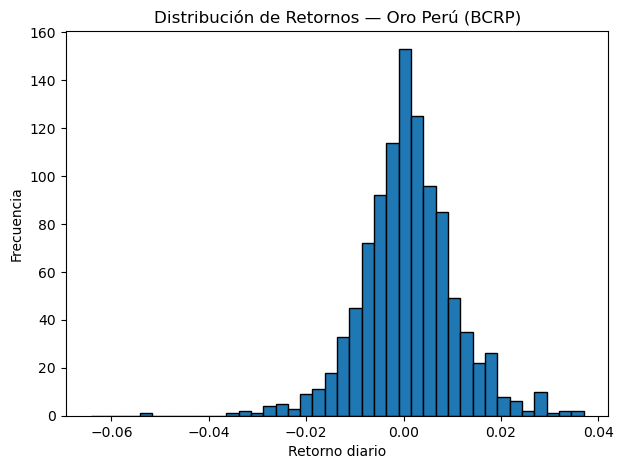

In [10]:
#HISTOGRAMA 1 - ORO PERÚ
plt.figure(figsize=(7,5))
plt.hist(
    peru_gold["ret"].dropna(),
    bins=bins,
    edgecolor="black"
)
plt.title("Distribución de Retornos — Oro Perú (BCRP)")
plt.xlabel("Retorno diario")
plt.ylabel("Frecuencia")
plt.show()

In [11]:
usa_gld = yfinance_download(
    ["GLD"],
    start=START_D,
    end=END_D
)

usa_gld["ticker"].value_counts()

ticker
GLD    994
Name: count, dtype: int64

In [12]:
gld = (
    usa_fixed[usa_fixed["ticker"] == "GLD"]
    .dropna(subset=["ret"])
    .sort_values("date")
    .copy()
)

gld["ret"].describe()

NameError: name 'usa_fixed' is not defined

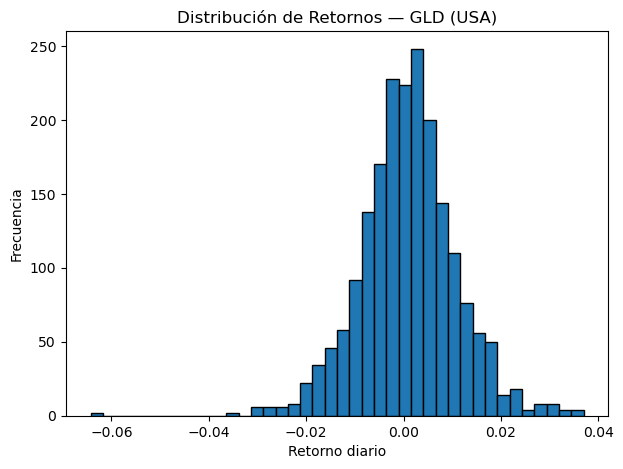

In [ ]:
#HISTOGRAMA 2 - GLD USA
plt.figure(figsize=(7,5))
plt.hist(
    gld["ret"].dropna(),
    bins=bins,
    edgecolor="black"
)
plt.title("Distribución de Retornos — GLD (USA)")
plt.xlabel("Retorno diario")
plt.ylabel("Frecuencia")
plt.show()

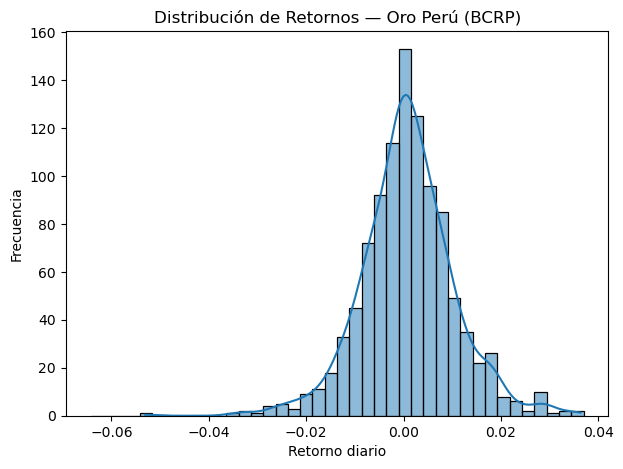

In [ ]:
#4. Optional: overlay KDE for each distribution.
#KDE + HISTOGRAMA ORO PERÚ
plt.figure(figsize=(7,5))

sns.histplot(
    peru_gold["ret"].dropna(),
    bins=bins,
    stat="count",
    kde=True
)

plt.title("Distribución de Retornos — Oro Perú (BCRP)")
plt.xlabel("Retorno diario")
plt.ylabel("Frecuencia")
plt.show()

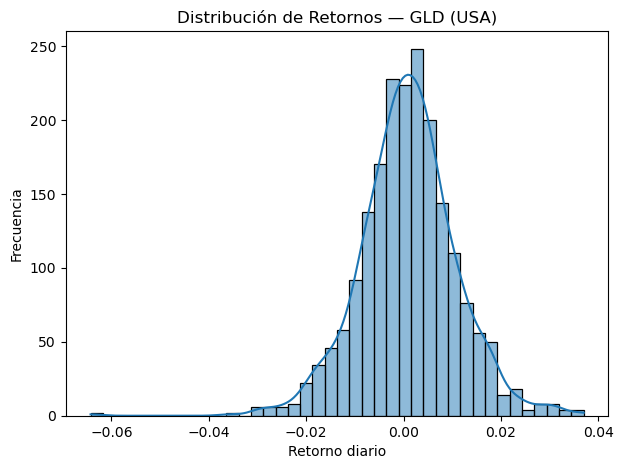

In [ ]:
#KDE + HISTOGRAMA GLD USA
plt.figure(figsize=(7,5))

sns.histplot(
    gld["ret"].dropna(),
    bins=bins,
    stat="count",
    kde=True
)

plt.title("Distribución de Retornos — GLD (USA)")
plt.xlabel("Retorno diario")
plt.ylabel("Frecuencia")
plt.show()

In [ ]:
#Exercise 3.2 — Annotations (mark a key event on a series)
#ENCONTRAR EL DÍA CON EL MAYOR RETORNO ABSOLUTO
#FILTRAMOS SPY DESDE usa
spy = usa[usa["ticker"] == "SPY"].copy()
spy[["date", "ret"]].dropna().head()

Price,date,ret
995,2022-01-04,-0.000335
996,2022-01-05,-0.019202
997,2022-01-06,-0.000939
998,2022-01-07,-0.003954
999,2022-01-10,-0.001244


In [ ]:
#HALLAMOS LA FECHA Y EL RETORNO 
idx_extreme = spy["ret"].abs().idxmax()

extreme_row = spy.loc[idx_extreme]

extreme_date = extreme_row["date"]
extreme_ret  = extreme_row["ret"]

extreme_date, extreme_ret

(Timestamp('2025-04-09 00:00:00'), np.float64(0.10501930183911301))

Text(0, 0.5, 'Retorno diario')

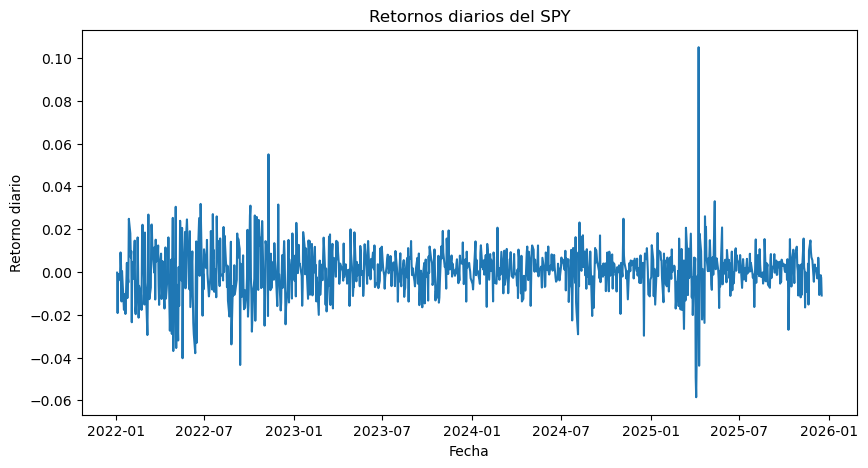

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(spy["date"], spy["ret"])
plt.title("Retornos diarios del SPY")
plt.xlabel("Fecha")
plt.ylabel("Retorno diario")

In [ ]:
#NOS ASEGURAMOS DE TENER EL SPY LIMPIO
spy_clean = (
    usa[usa["ticker"] == "SPY"]
    .dropna(subset=["ret"])
    .copy()
)

In [ ]:
#ENCONTRAMOS EL PUNTO EXTREMO
idx = spy_clean["ret"].abs().idxmax()
extreme_date = spy_clean.loc[idx, "date"]
extreme_ret  = spy_clean.loc[idx, "ret"]

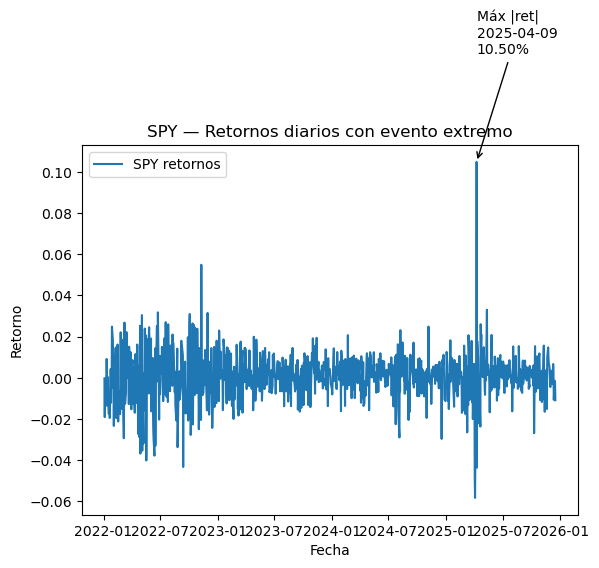

In [ ]:
#GRÁFICO Y ANOTACIÓN
plt.plot(spy_clean["date"], spy_clean["ret"], label="SPY retornos")
plt.annotate(
    f"Máx |ret|\n{extreme_date.date()}\n{extreme_ret:.2%}",
    xy=(extreme_date, extreme_ret),
    xytext=(extreme_date, extreme_ret * 1.5),
    arrowprops=dict(arrowstyle="->")
)

plt.title("SPY — Retornos diarios con evento extremo")
plt.xlabel("Fecha")
plt.ylabel("Retorno")
plt.legend()
plt.show()

In [ ]:
#4.2 Exercise 4.2
#RUN A SIMPLE REGRESSION OF GLD RETURNS ON SPY RETURNS
usa_gld = yfinance_download(
    ["GLD"],
    start=START_D,
    end=END_D
)

usa_gld["ticker"].value_counts()

ticker
GLD    994
Name: count, dtype: int64

In [ ]:
usa_fixed = pd.concat([usa, usa_gld], ignore_index=True)
usa_fixed["ticker"].value_counts()

ticker
GLD    1988
SPY     994
TLT     994
Name: count, dtype: int64

In [ ]:
#PRIMERO CONSTRUIMOS LOS RETORNOS ALINEADOS
#FILTRAMOS SPY Y GLD
spy = (
    usa_fixed[usa_fixed["ticker"] == "SPY"]
    [["date", "ret"]]
    .rename(columns={"ret": "ret_SPY"})
)

gld = (
    usa_fixed[usa_fixed["ticker"] == "GLD"]
    [["date", "ret"]]
    .rename(columns={"ret": "ret_GLD"})
)

In [ ]:
#ALINEAMOS POR FECHA
ret_aligned = (
    pd.merge(spy, gld, on="date", how="inner")
    .dropna()
)

ret_aligned.head()
ret_aligned.shape

(1986, 3)

In [ ]:
#CALCULAMOS ALPHA Y BETA
x = ret_aligned["ret_SPY"]
y = ret_aligned["ret_GLD"]

beta = np.cov(x, y, ddof=1)[0, 1] / np.var(x, ddof=1)
alpha = y.mean() - beta * x.mean()

alpha, beta

(np.float64(0.0008789945468910876), np.float64(0.10180354086179283))

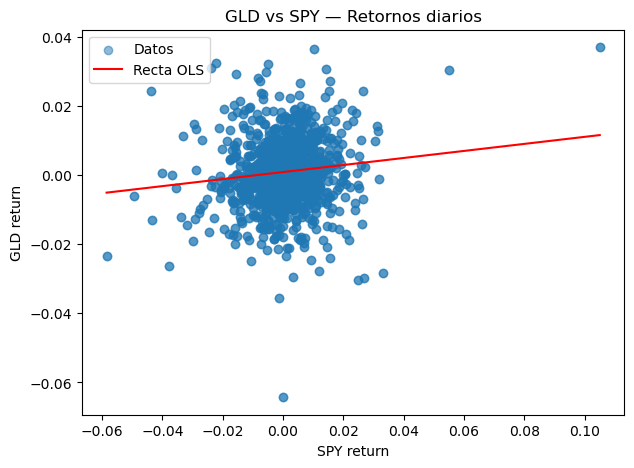

In [ ]:
#SCATTER + RECTA ESTIMADA
plt.figure(figsize=(7,5))
plt.scatter(x, y, alpha=0.5, label="Datos")

x_line = np.linspace(x.min(), x.max(), 100)
y_line = alpha + beta * x_line

plt.plot(x_line, y_line, color="red", label="Recta OLS")

plt.title("GLD vs SPY — Retornos diarios")
plt.xlabel("SPY return")
plt.ylabel("GLD return")
plt.legend()
plt.show()

In [ ]:
#INTERPRETACIÓN
#El coeficiente β mide la sensibilidad de los retornos de GLD frente a los retornos del mercado accionario estadounidense (SPY). 
#Un valor positivo de β indica que, en promedio, cuando SPY sube, GLD también tiende a subir. Sin embargo, dado que el valor de 
#β es menor que 1, la reacción de GLD es más moderada que la del mercado accionario.

Exercise 2.2 — Inspect the BCRPData API URL (requests) You are already downloading from BCRPData. Now you will inspect what is being requested.

Tasks

Recreate the API URL string used to download the Peru series. Print it. Download the CSV text using http_get_text and display the first 10 lines. Explain (in a markdown cell) what each part of the URL means.

In [13]:
# 1. Usar peru_wide (ya está en formato wide)
# 2. Renombrar columnas a nombres cortos
peru_clean = peru_wide.copy()

# Crear un mapeo más simple de nombres
rename_simple = {
    'fx_interbank_buy': 'fx_interbank',
    'fx_sbs_buy': 'fx_sbs',
    'gold_london': 'gold',
    'copper_london': 'copper'
}

peru_clean = peru_clean.rename(columns=rename_simple)

# 3. Crear cambios porcentuales diarios para FX y commodities
peru_clean['fx_interbank_ret'] = peru_clean['fx_interbank'].pct_change()
peru_clean['fx_sbs_ret'] = peru_clean['fx_sbs'].pct_change()
peru_clean['gold_ret'] = peru_clean['gold'].pct_change()
peru_clean['copper_ret'] = peru_clean['copper'].pct_change()

# 4. Eliminar filas donde todos los cuatro retornos son missing
return_cols = ['fx_interbank_ret', 'fx_sbs_ret', 'gold_ret', 'copper_ret']
peru_clean = peru_clean.dropna(subset=return_cols, how='all')

# Mostrar las primeras filas
print("Peru Clean Table:")
print(peru_clean.head(10))
print("\nColumnas:", peru_clean.columns.tolist())
print(f"Total filas: {len(peru_clean)}")

Peru Clean Table:
         date      copper     gold  fx_interbank  fx_sbs  fx_interbank_ret  \
1  2022-01-04  438.170229  1811.40      3.959500   3.963         -0.006066   
2  2022-01-05  443.522619  1826.25      3.952000   3.953         -0.001894   
3  2022-01-06  433.861102  1789.35      3.967167   3.967          0.003838   
4  2022-01-07  436.129064  1792.60      3.945167   3.948         -0.005546   
5  2022-01-10  438.397026  1794.20      3.927667   3.925         -0.004436   
6  2022-01-11  438.260948  1806.80      3.916333   3.919         -0.002886   
7  2022-01-12  451.097612  1821.40      3.892333   3.897         -0.006128   
8  2022-01-13  452.322311  1820.35      3.894833   3.895          0.000642   
9  2022-01-14  449.056446  1822.95      3.870333   3.879         -0.006290   
10 2022-01-17  438.827938  1817.85      3.847667   3.846         -0.005857   

    fx_sbs_ret  gold_ret  copper_ret  
1    -0.006020 -0.004780   -0.003302  
2    -0.002523  0.008198    0.012215  
3     

C:\Users\new user660003\AppData\Local\Temp\ipykernel_22668\1441635114.py:16: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  peru_clean['fx_interbank_ret'] = peru_clean['fx_interbank'].pct_change()
C:\Users\new user660003\AppData\Local\Temp\ipykernel_22668\1441635114.py:17: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  peru_clean['fx_sbs_ret'] = peru_clean['fx_sbs'].pct_change()


Exercise 3.1 Create a single figure with 2 subplots:

Top: Peru FX spread (SBS - interbank) Bottom: USA SPY close price Tasks

Build the Peru FX spread series from peru_w. Build SPY close series from usa_w. Use plt.subplots(nrows=2, ncols=1, sharex=True). Add titles, axis labels, and use fig.tight_layout().

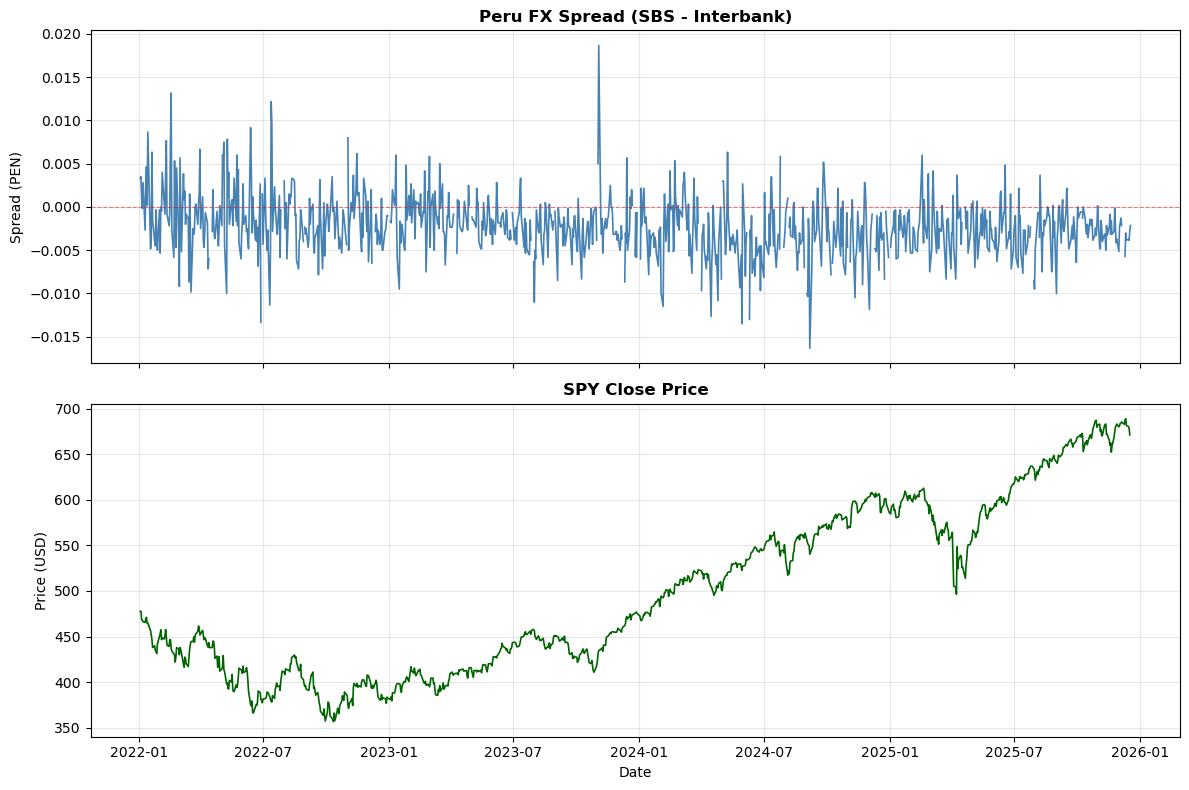

FX Spread - Mean: -0.0021
FX Spread - Std: 0.0034
SPY Close - Min: $356.56
SPY Close - Max: $689.17


In [14]:
import matplotlib.pyplot as plt

# 1. Construir la serie de spread de FX de Peru (SBS - interbank)
peru_spread = peru_wide.copy()
peru_spread['fx_spread'] = peru_spread['fx_sbs_buy'] - peru_spread['fx_interbank_buy']

# 2. Construir la serie de cierre de SPY desde usa
spy_data = usa[usa['ticker'] == 'SPY'][['date', 'close']].copy()
spy_data = spy_data.sort_values('date').reset_index(drop=True)

# 3. Crear figura con 2 subplots (compartiendo eje x)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

# Subplot superior: Peru FX spread
axes[0].plot(peru_spread['date'], peru_spread['fx_spread'], 
             color='steelblue', linewidth=1.2)
axes[0].set_title('Peru FX Spread (SBS - Interbank)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Spread (PEN)', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)

# Subplot inferior: SPY close price
axes[1].plot(spy_data['date'], spy_data['close'], 
             color='darkgreen', linewidth=1.2)
axes[1].set_title('SPY Close Price', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=10)
axes[1].set_ylabel('Price (USD)', fontsize=10)
axes[1].grid(True, alpha=0.3)

# 4. Ajustar layout
fig.tight_layout()
plt.show()

# Información adicional
print(f"FX Spread - Mean: {peru_spread['fx_spread'].mean():.4f}")
print(f"FX Spread - Std: {peru_spread['fx_spread'].std():.4f}")
print(f"SPY Close - Min: ${spy_data['close'].min():.2f}")
print(f"SPY Close - Max: ${spy_data['close'].max():.2f}")

### Exercise 3.3 — Saving the figure
Save one of your figures to disk.

**Tasks**
1. Create a folder `figures/` if it does not exist.
2. Save the subplot figure as `figures/lecture4II_fx_spy.png` with dpi=150.
3. Confirm the file exists.

In [ ]:
#TASK 1 --> Create a folder `figures/` if it does not exist
# ------------------------------------------------------------------------------
# Definimos la ruta de la carpeta.
# Usar 'Path' es mejor que usar strings simples ("figures/") porque se adapta
# automáticamente a Windows (barras invertidas \) o Mac/Linux (barras normales /).
output_folder = Path("figures")

# Creamos la carpeta física en el disco.
# parents=True: Si la ruta fuera "mis_reportes/2025/figures", crea todas las carpetas intermedias.
# exist_ok=True: "Código Defensivo". Si la carpeta YA existe, no hagas nada (no borres ni des error).
output_folder.mkdir(parents=True, exist_ok=True)

print(f"Task 1 completada. Carpeta lista en: {output_folder.resolve()}")

In [ ]:
# TASK 2 --> Save the subplot figure as `figures/lecture4II_fx_spy.png`
# ------------------------------------------------------------------------------
# Definimos la ruta completa del archivo final (Carpeta + Nombre de archivo).
# El operador '/' en pathlib une las rutas de forma inteligente.
save_path = output_folder / "lecture4II_fx_spy.png"

# Guardamos la figura que tenemos en memoria ('fig').
# dpi=150: "Dots Per Inch" (Píxeles por pulgada).
#          - 72: Baja calidad (Web antigua).
#          - 150: Calidad Estándar (Perfecto para Word/PPT y pantallas HD).
#          - 300: Alta Calidad (Imprenta/Papers académicos).
# bbox_inches='tight': "Bounding Box Tight".
#          Calcula el espacio mínimo necesario y recorta los márgenes blancos sobrantes.
#          Sin esto, a veces los títulos o números de los ejes salen cortados en la imagen.
fig.savefig(save_path, dpi=150, bbox_inches='tight')

print(f"Task 2 completada. Imagen guardada.")

In [ ]:
# TASK 3 --> Confirm the file exists
# ------------------------------------------------------------------------------
# Verificación final para asegurarnos de que el archivo realmente se creó.
# .exists() devuelve True si el archivo está ahí, False si falló.
if save_path.exists():
    print(f"Task 3 completada. ✅ ÉXITO: El archivo existe físicamente.")
    print(f"Ubicación: {save_path}")
else:
    print(f"Task 3 fallida. ❌ ERROR: El archivo no aparece.")

## 4) Statistics 
### Exercise 4.1 — Summary statistics table (returns)
Build a clean table of return moments.

**Tasks**
1. Create a wide daily returns table for SPY, TLT, GLD.
2. Compute: mean, std, skewness, kurtosis.
3. Present results as a DataFrame with tickers as rows.

In [ ]:
# TASK 1 --> Pivot to wide format (Assets as columns)
# ------------------------------------------------------------------------------
# - Filas = Días (Fechas)
# - Columnas = Activos (Tickers)
# - Valores = Retornos ('ret')

usa_rets_wide = usa.pivot_table(index="date", columns="ticker", values="ret")

# Visualización rápida para verificar que funcionó (opcional)
print(f"Task 1 completada. Tabla pivoteada con dimensiones: {usa_rets_wide.shape}")

In [ ]:
# TASK 2 --> Compute Mean, Std, Skewness, Kurtosis

stats_summary = usa_rets_wide.agg(['mean', 'std', 'skew', 'kurt'])

print("Task 2 completada. Estadísticas calculadas.")

In [ ]:
# TASK 3 --> Transpose and Present
stats_table = stats_summary.T

print("\n--- Summary Statistics Table ---")
print(stats_table)

## 5) Risk and Uncertainty 

### Exercise 5.1 — Historical VaR (95%) for a 60/40 portfolio
Portfolio:
- 60% SPY
- 40% TLT

**Tasks**
1. Create a wide returns table for SPY and TLT.
2. Compute portfolio daily returns.
3. Compute 1-day 95% Historical VaR (the 5th percentile of returns).
4. Compute 1-day 95% CVaR (average return below the 5th percentile).

In [ ]:
# 1. Create a wide returns table for SPY and TLT
# Definimos el periodo de tiempo (puedes ajustar las fechas según lo que pida tu profesor)
start_date = "2020-01-01"
end_date = "2023-12-31"
tickers = ['SPY', 'TLT']
# Descargamos solo el 'Adj Close' (Precio de cierre ajustado por dividendos/splits)
prices = yf.download(tickers, start=start_date, end=end_date)['Close']
# Calculamos retornos diarios
returns = prices.pct_change().dropna()

print("--- Tabla de Retornos (Primeras 5 filas) ---")
print(returns.head())
print("\n")

In [ ]:
# 2. Compute portfolio daily returns
# Pesos del portafolio: 60% SPY, 40% TLT
w_spy = 0.60
w_tlt = 0.40

# Calculamos el retorno ponderado
# Formula: Rp = w1*r1 + w2*r2
returns['Portfolio'] = (returns['SPY'] * w_spy) + (returns['TLT'] * w_tlt)

print("--- Retornos del Portafolio 60/40 ---")
print(returns['Portfolio'].head())
print("\n")

In [ ]:
# 3. Compute 1-day 95% Historical VaR (the 5th percentile)
# El VaR histórico es simplemente el cuantil empírico de la distribución.
# Nivel de confianza 95% => Buscamos el percentil 5 (0.05) de la cola izquierda.

var_95 = returns['Portfolio'].quantile(0.05)

print(f"--- 1-day 95% Historical VaR ---")
print(f"VaR (decimal): {var_95:.5f}")
print(f"VaR (porcentaje): {var_95:.2%}")
print("(Esto significa que hay un 5% de probabilidad de perder más de este monto en un día)")
print("\n")

In [ ]:
# 4. Compute 1-day 95% CVaR (average return below the 5th percentile)
# El CVaR (o Expected Shortfall) es el promedio de las pérdidas que superan el VaR.
# Filtramos todos los retornos que sean MENORES o IGUALES al VaR calculado antes.

losses_exceeding_var = returns[returns['Portfolio'] <= var_95]['Portfolio']
cvar_95 = losses_exceeding_var.mean()

print(f"--- 1-day 95% Historical CVaR ---")
print(f"CVaR (decimal): {cvar_95:.5f}")
print(f"CVaR (porcentaje): {cvar_95:.2%}")
print("(Si el mercado colapsa más allá del VaR, esta es la pérdida promedio esperada)")